In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import warnings

# Отключение предупреждений
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Часть 1: Генерация данных и построение множественной линейной регрессии
print("="*50)
print("ЧАСТЬ 1: МНОЖЕСТВЕННАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ")
print("="*50)

np.random.seed(42)
n = 200
X = np.random.normal(0, 1, (n, 3))  # x1, x2, x3 ~ N(0,1)
e = np.random.normal(0, 1, n)
y = 1 + 3 * X[:, 0] - 2 * X[:, 1] + X[:, 2] + e

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print("Сводка множественной линейной регрессии:")
print(model.summary())


ЧАСТЬ 1: МНОЖЕСТВЕННАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ
Сводка множественной линейной регрессии:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     744.5
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          7.85e-107
Time:                        14:52:32   Log-Likelihood:                -285.03
No. Observations:                 200   AIC:                             578.1
Df Residuals:                     196   BIC:                             591.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [2]:

# Часть 2: Расчет RSS, RSE, R^2
print("\n" + "="*50)
print("ЧАСТЬ 2: МЕТРИКИ МОДЕЛИ И ОЦЕНКА АДЕКВАТНОСТИ")
print("="*50)

RSS = model.ssr
df_residual = n - 4  # n - p - 1, p=3 factors
RSE = np.sqrt(RSS / df_residual)
R_squared = model.rsquared
adj_R_squared = model.rsquared_adj

print("\nМетрики модели:")
print(f"RSS (Сумма квадратов остатков): {RSS:.4f}")
print(f"RSE (Стандартная ошибка остатков): {RSE:.4f}")
print(f"R² (Коэффициент детерминации): {R_squared:.4f}")
print(f"Скорректированный R²: {adj_R_squared:.4f}")

# Сравнение коэффициентов
true_coeffs = [1, 3, -2, 1]
estimated_coeffs = model.params
print(f"\nСравнение коэффициентов:")
print(f"Истинные коэффициенты: {true_coeffs}")
print(f"Оцененные коэффициенты: {[f'{c:.4f}' for c in estimated_coeffs]}")

print("\nОценка адекватности модели:")
if R_squared > 0.9:
    print("✓ ОТЛИЧНО: R² > 0.9 указывает, что модель объясняет более 90% дисперсии")
    print("✓ Линейная модель высоко адекватна для сгенерированных данных")
else:
    print("⚠️ Модель может нуждаться в улучшении")



ЧАСТЬ 2: МЕТРИКИ МОДЕЛИ И ОЦЕНКА АДЕКВАТНОСТИ

Метрики модели:
RSS (Сумма квадратов остатков): 202.5066
RSE (Стандартная ошибка остатков): 1.0165
R² (Коэффициент детерминации): 0.9193
Скорректированный R²: 0.9181

Сравнение коэффициентов:
Истинные коэффициенты: [1, 3, -2, 1]
Оцененные коэффициенты: ['1.0188', '2.9762', '-1.9076', '1.1185']

Оценка адекватности модели:
✓ ОТЛИЧНО: R² > 0.9 указывает, что модель объясняет более 90% дисперсии
✓ Линейная модель высоко адекватна для сгенерированных данных


In [4]:

# Часть 3: Полиномиальная регрессия с прямым отбором
print("\n" + "="*50)
print("ЧАСТЬ 3: ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ С ПРЯМЫМ ОТБОРОМ")
print("="*50)

df_temp = pd.read_excel('data/saint_petersburg_temperatures.xlsx')

# Улучшенный прямой отбор с несколькими критериями
def improved_forward_selection(y, X_poly, feature_names, max_features=10):
    """
    Улучшенный прямой отбор с несколькими критериями
    """
    selected = []
    remaining = list(range(X_poly.shape[1]))
    results = []
    
    print(f"\nПроцесс прямого отбора (макс. {max_features} признаков):")
    print("-" * 60)
    
    for step in range(1, max_features + 1):
        best_feature = None
        best_score = -np.inf
        best_model = None
        
        for feature in remaining:
            candidate_features = selected + [feature]
            X_candidate = sm.add_constant(X_poly[:, candidate_features])
            
            model = sm.OLS(y, X_candidate).fit()
            # Использование скорректированного R² как основного критерия
            score = model.rsquared_adj
            
            if score > best_score:
                best_score = score
                best_feature = feature
                best_model = model
        
        if best_feature is not None:
            selected.append(best_feature)
            remaining.remove(best_feature)
            
            feature_name = feature_names[best_feature]
            results.append({
                'step': step,
                'feature': feature_name,
                'R²': best_model.rsquared,
                'Adj R²': best_model.rsquared_adj,
                'AIC': best_model.aic,
                'BIC': best_model.bic
            })
            
            print(f"Шаг {step}: Добавлен {feature_name:15} | "
                  f"R² = {best_model.rsquared:.4f} | "
                  f"Adj R² = {best_model.rsquared_adj:.4f} | "
                  f"AIC = {best_model.aic:.2f}")
    
    # Финальная модель со всеми выбранными признаками
    X_final = sm.add_constant(X_poly[:, selected])
    final_model = sm.OLS(y, X_final).fit()
    
    return final_model, selected, results

# Подготовка полиномиальных признаков
year_mean = df_temp['Year'].mean()
df_temp['year_centered'] = df_temp['Year'] - year_mean

# Создание полиномиальных признаков до степени 5
centered_df = pd.DataFrame({'year_centered': df_temp['year_centered']})
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(centered_df)
poly_features = poly.get_feature_names_out(['year_centered'])

# Запуск улучшенного прямого отбора
final_model, selected_features, selection_results = improved_forward_selection(
    df_temp['Annual_Avg'], X_poly, poly_features, max_features=10
)

print(f"\nВыбранные признаки: {[poly_features[i] for i in selected_features]}")
print(f"R² финальной модели: {final_model.rsquared:.4f}")
print(f"Скорректированный R² финальной модели: {final_model.rsquared_adj:.4f}")



ЧАСТЬ 3: ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ С ПРЯМЫМ ОТБОРОМ

Процесс прямого отбора (макс. 10 признаков):
------------------------------------------------------------
Шаг 1: Добавлен year_centered   | R² = 0.3459 | Adj R² = 0.3114 | AIC = 41.01
Шаг 2: Добавлен year_centered^9 | R² = 0.3642 | Adj R² = 0.2936 | AIC = 42.41
Шаг 3: Добавлен year_centered^10 | R² = 0.3822 | Adj R² = 0.2732 | AIC = 43.81
Шаг 4: Добавлен year_centered^2 | R² = 0.4326 | Adj R² = 0.2907 | AIC = 44.02
Шаг 5: Добавлен year_centered^8 | R² = 0.4559 | Adj R² = 0.2745 | AIC = 45.14
Шаг 6: Добавлен year_centered^4 | R² = 0.6610 | Adj R² = 0.5157 | AIC = 37.20
Шаг 7: Добавлен year_centered^3 | R² = 0.6724 | Adj R² = 0.4960 | AIC = 38.49
Шаг 8: Добавлен year_centered^6 | R² = 0.6736 | Adj R² = 0.4559 | AIC = 40.41
Шаг 9: Добавлен year_centered^5 | R² = 0.6742 | Adj R² = 0.4076 | AIC = 42.37
Шаг 10: Добавлен year_centered^7 | R² = 0.7265 | Adj R² = 0.4529 | AIC = 40.70

Выбранные признаки: ['year_centered', 'year_centered^9', '

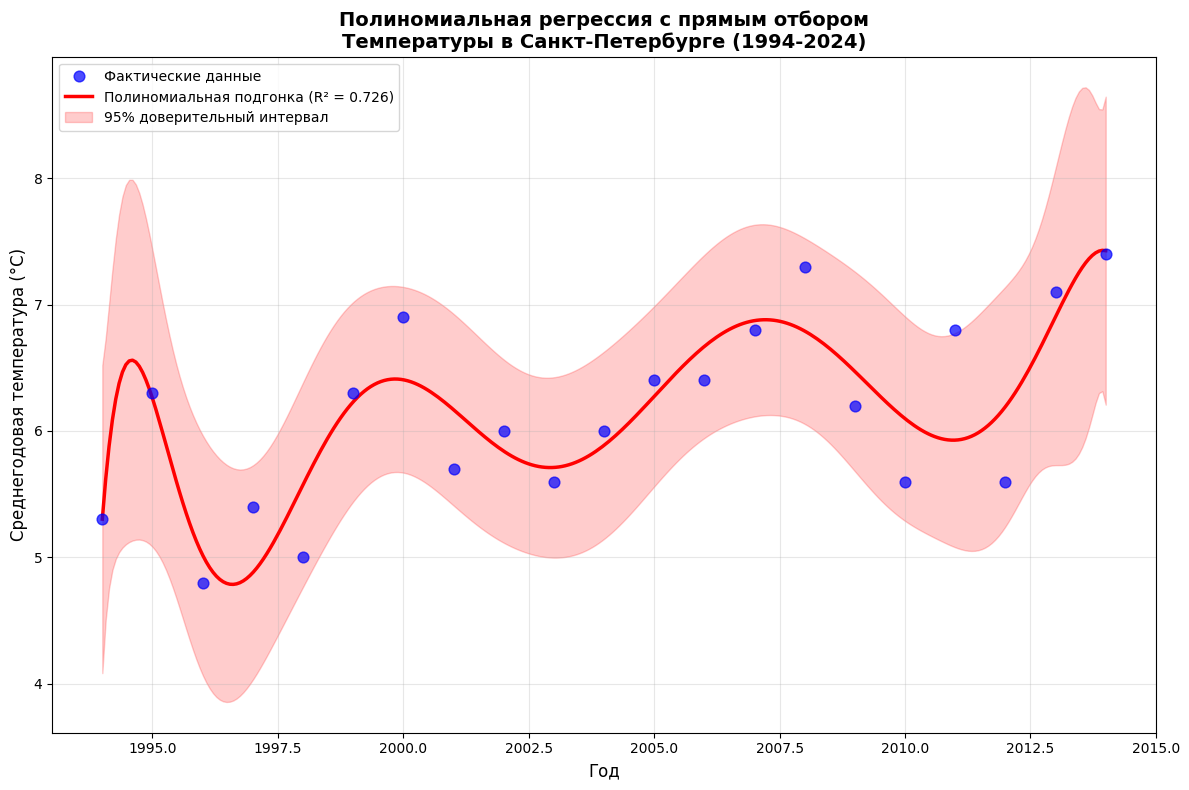

In [5]:
# Улучшенная визуализация
plt.figure(figsize=(12, 8))

# График исходных данных
plt.scatter(df_temp['Year'], df_temp['Annual_Avg'], 
           color='blue', s=60, alpha=0.7, label='Фактические данные', zorder=5)

# Создание гладкой кривой предсказания
years_continuous = np.linspace(df_temp['Year'].min(), df_temp['Year'].max(), 300)
years_continuous_centered = years_continuous - year_mean

# Трансформация с использованием DataFrame для избежания предупреждений
cont_df = pd.DataFrame({'year_centered': years_continuous_centered})
X_cont_poly = poly.transform(cont_df)
X_cont_selected = sm.add_constant(X_cont_poly[:, selected_features])
y_cont_pred = final_model.predict(X_cont_selected)

# График кривой подгонки
plt.plot(years_continuous, y_cont_pred, 
         color='red', linewidth=2.5, 
         label=f'Полиномиальная подгонка (R² = {final_model.rsquared:.3f})')

# Добавление доверительного интервала
predictions = final_model.get_prediction(X_cont_selected)
frame = predictions.summary_frame(alpha=0.05)
plt.fill_between(years_continuous, 
                 frame['mean_ci_lower'], 
                 frame['mean_ci_upper'],
                 color='red', alpha=0.2, label='95% доверительный интервал')

plt.xlabel('Год', fontsize=12)
plt.ylabel('Среднегодовая температура (°C)', fontsize=12)
plt.title('Полиномиальная регрессия с прямым отбором\nТемпературы в Санкт-Петербурге (1994-2024)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
# Дополнительный анализ
print(f"\nДополнительный анализ:")
print(f"Тренд температуры: +{df_temp['Annual_Avg'].iloc[-1] - df_temp['Annual_Avg'].iloc[0]:.2f}°C за период")
print(f"Средняя температура: {df_temp['Annual_Avg'].mean():.2f}°C")
print(f"Стандартное отклонение температуры: {df_temp['Annual_Avg'].std():.2f}°C")


Дополнительный анализ:
Тренд температуры: +2.10°C за период
Средняя температура: 6.14°C
Стандартное отклонение температуры: 0.74°C
